# Andrea Ambrosini - Segmentation 

## Import libriries 

In [ ]:
import cv2 as cv
import spectral as spec
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
from PIL import Image

## Import Images

In [3]:
# Find the jpg files
search_dir = "./"
# Get a list of all .jpg files in the directory and its subdirectories
jpg_files = glob.glob(os.path.join(search_dir, "**", "*.jpg"), recursive=True)
print(jpg_files)
jpg_images = []
for f in jpg_files:
    try:
        jpg_images.append(Image.open(f))
    except Exception as e:
        print(f"Error in opeining the file {f}: {e}")

# Print dei risultati
print("Found {} images JPG, first 3 are:".format(len(jpg_images)))
for i, img in enumerate(jpg_images[:3]):
    print(f"{i+1}: {jpg_files[i]} - size {img.size}")


['./Sagai-RGB/Sagai_1-14_lab lamp__2025-07-23T12-40-54.083.jpg', './Sagai-RGB/Sagai_1-14_lab lamp__2025-07-23T12-43-02.879.jpg', './Sagai-RGB/Sagai_1-14_lab lamp__2025-07-23T12-45-23.821.jpg', './Sagai-RGB/Sagai_1-14_lab lamp__2025-07-23T12-46-52.039.jpg', './Sagai-RGB/Sagai_1-14_lab lamp__2025-07-23T12-48-23.309.jpg', './Sagai-RGB/Sagai_1-14_LED_cold__2025-07-23T10-59-12.536.jpg', './Sagai-RGB/Sagai_1-14_LED_cold__2025-07-23T11-00-02.233.jpg', './Sagai-RGB/Sagai_1-14_LED_cold__2025-07-23T11-01-13.437.jpg', './Sagai-RGB/Sagai_1-14_LED_cold__2025-07-23T11-02-02.454.jpg', './Sagai-RGB/Sagai_1-14_LED_cold__2025-07-23T12-22-08.879.jpg', './Sagai-RGB/Sagai_1-14_LED_mixed__2025-07-23T12-22-36.002.jpg', './Sagai-RGB/Sagai_1-14_LED_mixed__2025-07-23T12-24-19.748.jpg', './Sagai-RGB/Sagai_1-14_LED_mixed__2025-07-23T12-25-10.865.jpg', './Sagai-RGB/Sagai_1-14_LED_mixed__2025-07-23T12-26-25.313.jpg', './Sagai-RGB/Sagai_1-14_LED_mixed__2025-07-23T12-27-32.61.jpg', './Sagai-RGB/Sagai_1-14_LED_warm__2

## Plotting data

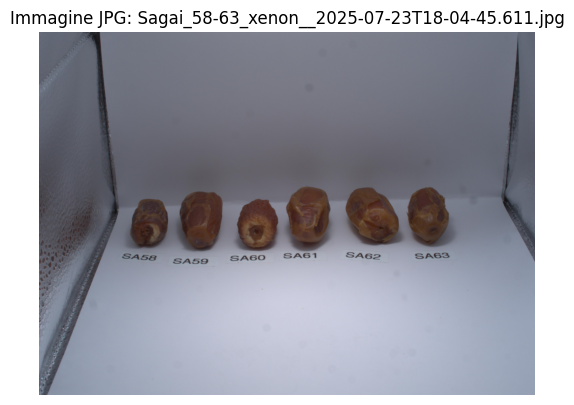

In [ ]:
example_jpg = jpg_files[-1]
img = Image.open(example_jpg)

plt.figure()
plt.imshow(img)
plt.title(f'Immagine JPG: {os.path.basename(example_jpg)}')
plt.axis('off')
plt.show()

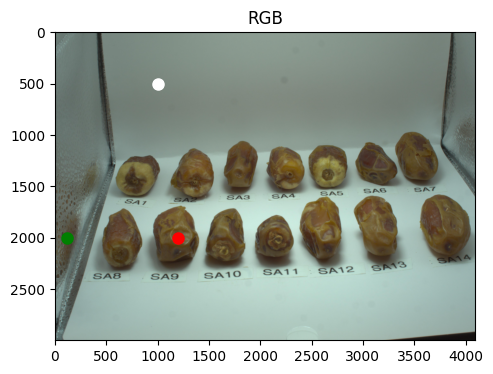

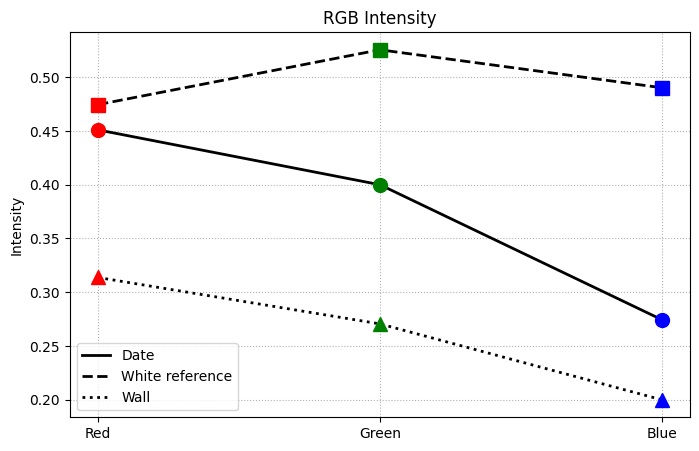

In [ ]:
# Load image
img_np = np.array(img)

# Coordinates of points of interest (y, x)
pos = [2000, 1200,  # Date 
       500, 1000,  # White reference 
       2000, 120]  # Wall 

plt.figure(figsize=(20, 4))

# Mark 3 points
plt.imshow(img_np)
plt.title('RGB')
plt.plot(pos[1], pos[0], 'ro', markersize=8)
plt.plot(pos[3], pos[2], 'wo', markersize=8)
plt.plot(pos[5], pos[4], 'go', markersize=8)

# Plotting the RGB intensity of each point of interest
channels = ['Red', 'Green', 'Blue']

rgb_values = np.array([img_np[pos[2*i], pos[2*i+1], :]/255 for i in range(len(channels))]) # Normalizing the intensity of the RGB values
means = np.array([np.mean(img_np[:,:,:],axis=(0,1))])
plt.figure(figsize=(8,5))

channel_colors = ['red', 'green', 'blue']    
markers = ['o', 's', '^']
linestyles = ['-', '--', ':']
label = ["Date","White reference","Wall"]
for i in range(len(channels)):
    # Lines Plot 
    plt.plot(channels, rgb_values[i], color="black", linestyle=linestyles[i],
             linewidth=2, label=label[i])
    # Markers Plot 
    for j, channel in enumerate(channels):
        plt.plot(channel, rgb_values[i, j], marker=markers[i], color=channel_colors[j],
                 markersize=10)
plt.ylabel('Intensity')
plt.title('RGB Intensity')
plt.grid(True, linestyle=':')
plt.legend()
plt.show()


## Functions Definition

### Function for labelling dates

In [63]:
from skimage.measure import label, regionprops

def ext_label(data):
# Labelling 
    normalization = data[:,:,2] # It will be use to do some normalization for the blue values
    b_min = np.min(normalization[normalization > 0.3]) # Minimum value of blue in the image 
    #print(b_min)
    #print(np.mean(normalization))
    b_max = np.max(normalization[normalization <0.8])  # maximum value of blue in the image under a certain threshold
    #print(b_max)
   
    mask = ((data[:,:,2]-np.mean(normalization)))<-0.15 # We exploit the fact that the intensity of blue in dates is very low
    mask[:,:400] = 0
    label_image = label(mask[:, :])
    regions = regionprops(label_image) # Group each date into a region
    # Define some min and max areas
    min_area = 5e4
    max_area = 5e5
    max_height = 1e3
    max_width = 5e2
    min_height = 3e2
    min_width = 2e2
    # Finding valid regions
    valid_regions = [r for r in regions if 
                     (r.area >= min_area) & (r.area < max_area)   
                     & ( (r.bbox[2] - r.bbox[0]) < max_height)
                     & ( (r.bbox[2] - r.bbox[0]) > min_height)
                     & ( (r.bbox[3] - r.bbox[1]) < max_width)   
                     & ( (r.bbox[3] - r.bbox[1]) > min_width)
                     ]
    # If valid regions is empy, plot the image
    if len(valid_regions) == 0:
        print("No regions found...")
        plt.figure(figsize=(10, 6))
        plt.imshow(mask)
        plt.axis("off")
        plt.show()
        return []  

    heights = [( r.bbox[2] - r.bbox[0]) for r in valid_regions]
    widths = [(r.bbox[3] - r.bbox[1]) for r in valid_regions]
    #print( np.mean(heights))
    #print(np.mean(widths))
    row_height = np.mean(heights) #  Used to approximate the size of a row, in this way dates that are in the same row will have the same Y coordinate
    col_width = np.mean(widths)  # Used to approximate the size of a column, in this way dates that are in the same col#umn will have the same X coordinate
    valid_regions = sorted(valid_regions,
                        key=lambda r: (
                            np.floor((r.centroid[0] )/  (row_height ** 1.02)),
                            np.floor((r.centroid[1])/ (col_width**1.02))
                        ))
    return valid_regions

### Function for plotting selected dates

In [36]:
def plot_regions(array):
    regions = ext_label(array)
    fig, ax = plt.subplots()
    ax.imshow(array[:,:,2], cmap='gray')

    for idx, r in enumerate(regions):
        y, x = r.centroid # Find the center of the region
        ax.text(x, y, idx+1, color='red', fontsize=10, ha='center', va='center')
        # Draw bounding box
        minr, minc, maxr, maxc = r.bbox
        rect = plt.Rectangle((minc, minr), maxc-minc, maxr-minr,
                            fill=False, edgecolor='green', linewidth=3)
        ax.add_patch(rect)
    plt.tight_layout()
    plt.show()

### Function for extracting RGB values 

In [37]:
def data_extraction(jpg_image):
    #w, h = jpg_image.size
    array = np.array(jpg_image,dtype=np.float32) / 255.0 # Normalize the RGB values
    regions = ext_label(array)
    data = np.zeros((len(regions),3)) # Initialize the output data

    for d in range(len(regions)): # Extracting the data from each date of the photo
        minr, minc, maxr, maxc = regions[d].bbox # Coordinates of a single date
        data[d,:] = np.mean(array[minr:maxr, minc:maxc,:],axis = (0,1)) # Extract RGB mean value for each date
    return data

## Plot

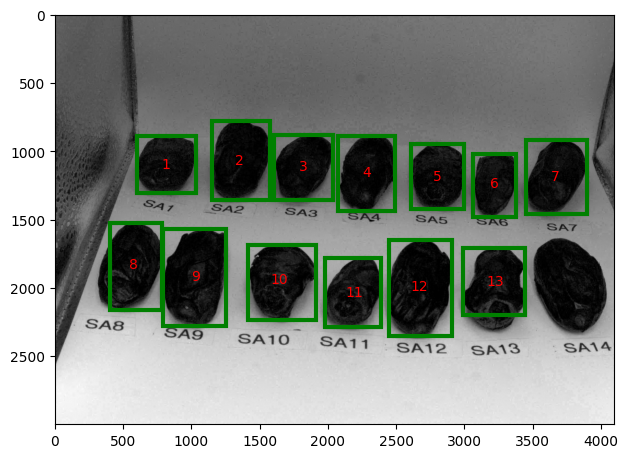

In [68]:
plot_regions(np.array(jpg_images[0],dtype=np.float32) / 255.0 )

##  Data extraction

In [64]:
var = []
for v in range(1): # 3 varieties 
    light = []
    for l in range(6): # 6 lamps 
        color = []
        for g in range(5): # 5 groups 
            for r in range(5): # 5 rotations
                color.append(data_extraction(jpg_images[150*v + 30*g + 5*l +  r])) # Extract RGB values from all the photosù
        light.append(color)
    var.append(light)

In [66]:
for i in range(25):print(len(var[0][0][i]))

13
14
14
13
13
13
13
11
14
11
13
14
13
14
14
12
10
12
13
11
5
6
5
6
6


## Mean values and standard deviations

### Data extraction

In [ ]:
mean_var = []
std_var = []

for v in range(1): # 3 varieties 
    mean_light = []
    std_light = []
    for l in range(6): # 6 lamps 
        stacked = np.stack(var[v][l][:25], axis=0)  # Put together 25 photos (they have the same illumation setup), we get a shape of (25, 16, 3)
        mean_light.append(np.mean(stacked, axis=(0, 1))) 
        std_light.append(np.std(stacked, axis=(0, 1)))    

    mean_var.append(mean_light)
    std_var = []
print(mean_var[0][1])

ValueError: all input arrays must have the same shape

### Mean values and standard deviations computation

In [ ]:
rot_mean = []
rot_std = []
v_mean = []
v_std = []

for a in range (3): # Consider every varieties    
    # Temporary lists
    rm = []
    rs =[]
    for v in range(3): # Consider the photos of dates belonging to the same variety

        for d in range(len(date[a][v][0])): # Considering all the dates in a photo with different rotations
            avg = np.mean([date[a][v][rot][d] for rot in range(3)],axis = 0)            
            std = np.sqrt(np.mean([(date[a][v][rot][d]-avg)**2 for rot in range(3)],axis = 0))
            rm.append(avg) # Mean value for a single date done across all its 3 rotations
            rs.append(std) # Variance for a single date done across all its 3 rotations
    rot_mean.append(rm)
    rot_std.append(rs)
    
    avg = np.mean([rot_mean[a][date] for date in range(len(rot_mean[a]))],axis = 0)
    std = np.sqrt(np.mean([(rot_mean[a][date]-avg)**2 for date in range(len(rot_mean[a]))],axis = 0))
    v_mean.append(avg) # Mean value of a single variety
    v_std.append(std) # Variance of a single variety
total_mean = np.mean([v_mean[var] for var in range(3)],axis = 0)
total_std = np.sqrt(np.mean([(v_mean[var]-total_mean)**2 for var in range(3)],axis = 0)) # Maybe do the std across all the dates


### Plotting

In [ ]:
d = -1 # Date
images = [
    item
    for a in range(3)
    for item in [rot_mean[a][d], rot_std[a][d], v_mean[a], v_std[a]]
]

titles = ["Mean Value Single Sukkari Date", "Standard Deviation Single Sukkari Date", "Mean value Sukkari","Standard Deviation Sukkari",
          "Mean Value Single Khudri Date", "Standard Deviation Single Khudri Date", "Mean value Khudri","Standard Deviation Khudri",
          "Mean Value Single Sagei Date", "Standard Deviation Single Sagei Date", "Mean value Sagei","Standard Deviation Sagei",]

fig, axs = plt.subplots(3, 4, figsize=(20, 8))  # aumenta un po' l'altezza

for idx, ax in enumerate(axs.flat):  
    ax.plot(wave, images[idx])
    ax.set_title(titles[idx])
    ax.grid(True, linestyle=':')
    ax.set_xlabel("Wavelenght")
    ax.set_ylabel("Reflactence")

plt.tight_layout()
plt.show()

NameError: name 'rot_mean' is not defined

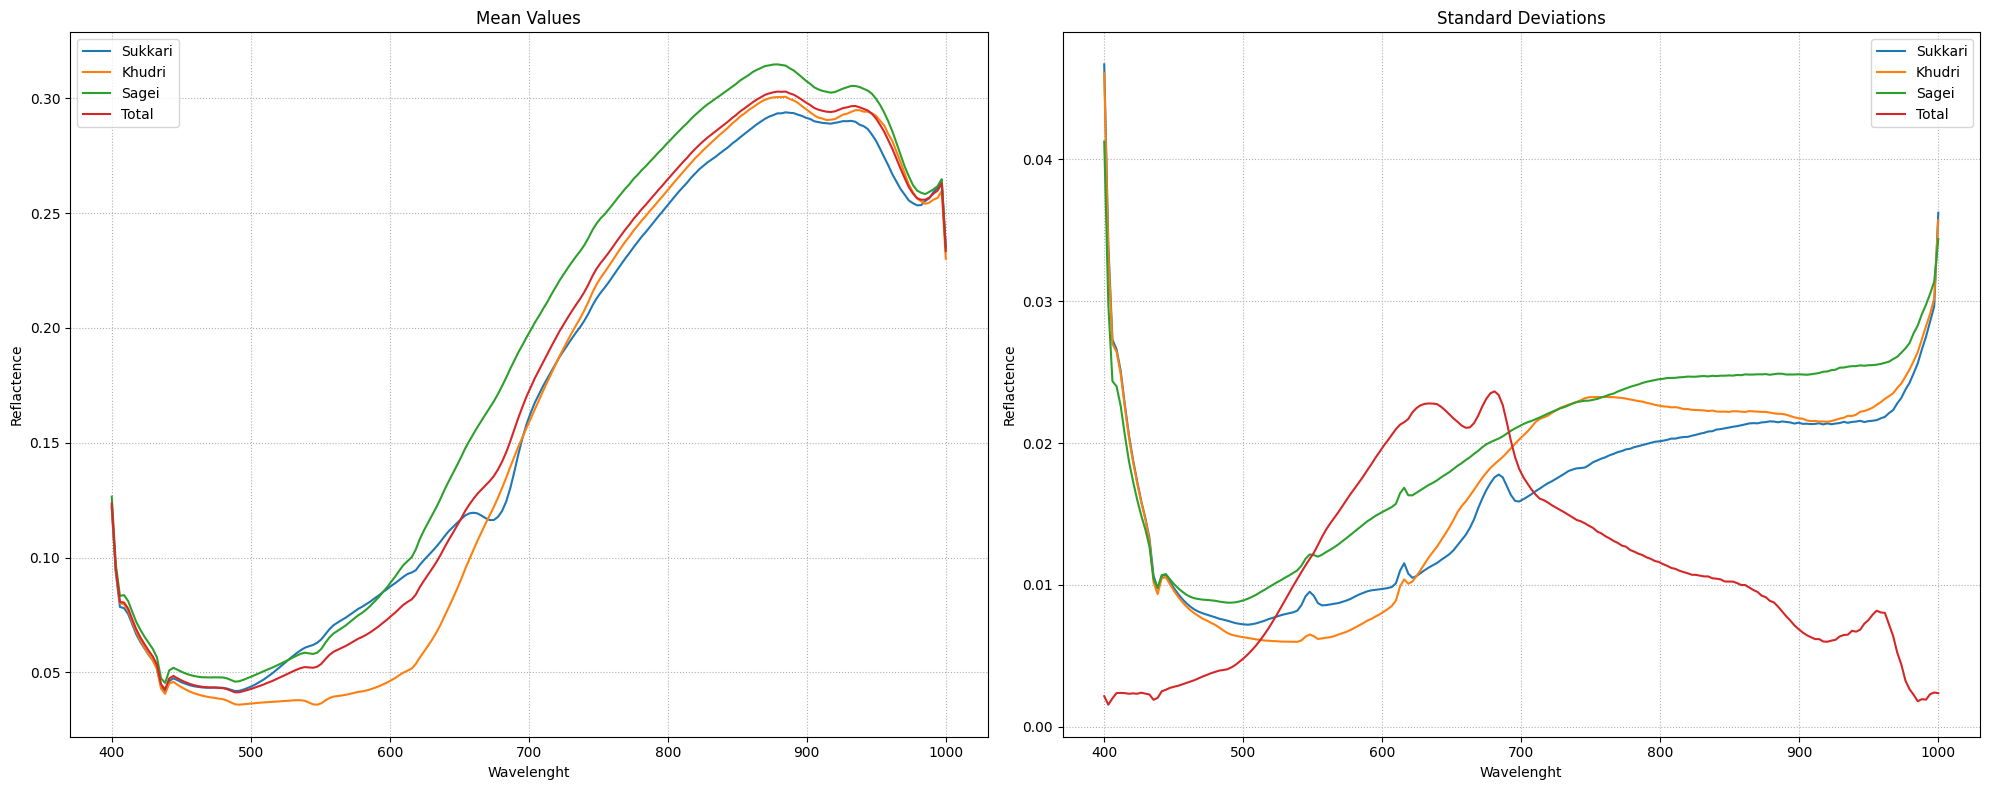

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # aumenta un po' l'altezza
labels = ["Sukkari", "Khudri", "Sagei"]

for i, label in enumerate(labels):
    axs[0].plot(wave, images[4*i+2], label=label)
    axs[1].plot(wave, images[4*i+3], label=label)

axs[0].plot(wave, total_mean, label="Total")
axs[1].plot(wave, total_var, label="Total")


axs[0].set_title("Mean Values")
axs[0].set_xlabel("Wavelenght")
axs[0].set_ylabel("Reflactence")

axs[0].grid(True, linestyle=':')
axs[0].legend()

axs[1].set_title("Standard Deviations")
axs[1].set_xlabel("Wavelenght")
axs[1].set_ylabel("Reflactence")
axs[1].grid(True, linestyle=':')
axs[1].legend()

plt.tight_layout()
plt.show()
